## Import necessary packages

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import scipy
import pandas as pd
import seaborn as sns
from scipy.stats import norm, bernoulli
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os, sys
import matplotlib.patheffects as pe
from plot_utils import make_width_coverage_plot, get_data, transform_features, make_length_table, make_coverage_table, make_error_table
import warnings; warnings.simplefilter('ignore')
from tqdm import tqdm
from baselines import classical_ols_ci
from ppi import ppi_ols_ci
from reppi import ppi_opt_ols_ci_crossfit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
np.random.seed(1)

## Import the ACS dataset

In [4]:
features = ['AGEP','SCHL','MAR','DIS','CIT','MIG','MIL','ANC1P','NATIVITY','DEAR','DEYE','DREM','SEX','RAC1P', 'SOCP', 'COW']
ft = np.array(["q", "q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])

income_features, income, employed = get_data(year=2019, features=features, outcome='PINCP')
income = income[(income_features['SCHL']!=24) & (income_features['SCHL']!=-1)]
income_features = income_features[(income_features['SCHL']!=24) & (income_features['SCHL']!=-1)]

In [5]:
n_acs = len(income)
n_tr = int(n_acs*0.5)

income = np.log(income)

income_features_train, income_features_unlabeled, income_train, Y = train_test_split(income_features, income, train_size=n_tr)
income_train = income_train.to_numpy()

income_train = income_train[income_features_train['SCHL']>=22]
income_features_train = income_features_train[income_features_train['SCHL']>=22]

X = np.stack([income_features_unlabeled['AGEP'].to_numpy(), income_features_unlabeled['SEX'].to_numpy()], axis=1)
Y = Y.to_numpy()

age = income_features['AGEP'].to_numpy()
sex = income_features['SEX'].to_numpy()
theta_true = np.linalg.pinv(np.stack([age, sex], axis=1)).dot(income.to_numpy())[0] # our estimand is first coordinate (effect of age)

In [6]:
income_features = income_features.drop(columns=['AGEP', 'SEX'])
income_features_train = income_features_train.drop(columns=['AGEP', 'SEX'])
income_features_unlabeled = income_features_unlabeled.drop(columns=['AGEP', 'SEX'])
ft = np.array(["q", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c", "c"])

In [7]:
print(n_tr)

132395


### Train XGBoost model

In [8]:
income_features_enc, enc = transform_features(income_features, ft)
income_features_train = transform_features(income_features_train, ft, enc)[0]
income_features_unlabeled = transform_features(income_features_unlabeled, ft, enc)[0]
print(income_features_train.shape, income_train.shape)
dtrain = xgb.DMatrix(income_features_train, label=income_train)
tree = xgb.train({'eta': 0.3, 'max_depth': 7, 'objective': 'reg:absoluteerror'}, dtrain, 1000)
Yhat = tree.predict(xgb.DMatrix(income_features_unlabeled))

(16542, 807) (16542,)


## Main experiment

Forms dataframe ```df``` with experiment results. The columns in the dataframe are:

- ```lb``` - interval lower bound

- ```ub``` - interval upper bound

- ```interval width``` - equal to ```ub``` - ```lb```

- ```coverage``` - True/False of whether or not interval covered target

- ```estimator``` - one of ```classical``` and ```PPI```

- ```$n$``` - size of labeled data

In [9]:
n_all = n_acs - n_tr
num_trials = 50
alpha = 0.1
labeled_fracs = np.linspace(0.05,0.20,30)

In [10]:
results = []
columns = ["lb", "ub", "interval width", "coverage", "estimator", "n", "mse"]
temp_df = pd.DataFrame(np.zeros((4,len(columns))), columns=columns)
error = np.zeros(4)

for j in tqdm(range(len(labeled_fracs))):
    n = int(labeled_fracs[j]*n_all)
    
    for i in tqdm(range(num_trials)):   
        labeled = np.random.choice(range(n_all), n, replace=False)
        unlabeled = list(set(range(n_all)) - set(labeled))
        X_lab = X[labeled]
        Y_lab = Y[labeled]
        Yhat_lab = Yhat[labeled]
        X_unlab = X[unlabeled]
        Yhat_unlab = Yhat[unlabeled]
        
        
        l, u = classical_ols_ci(X_lab, Y_lab, alpha=alpha)
        coverage = int((theta_true >= l[0])*(theta_true <= u[0]))
        mse = np.abs(l[0]+u[0]-2*theta_true)/2
        temp_df.loc[0] = l[0], u[0], (u[0] - l[0]), coverage, "XY-only", n, mse
        error[0] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, lhat=1)
        coverage = int((theta_true >= l[0])*(theta_true <= u[0]))
        mse = np.abs(l[0]+u[0]-2*theta_true)/2
        temp_df.loc[1] = l[0], u[0], (u[0] - l[0]), coverage, "PPI", n, mse
        error[1] += mse

        l, u = ppi_ols_ci(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha)
        coverage = int((theta_true >= l[0])*(theta_true <= u[0]))
        mse = np.abs(l[0]+u[0]-2*theta_true)/2
        temp_df.loc[2] = l[0], u[0], (u[0] - l[0]), coverage, "PPI++", n, mse
        error[2] += mse
        
        l, u = ppi_opt_ols_ci_crossfit(X_lab, Y_lab, Yhat_lab, X_unlab, Yhat_unlab, alpha=alpha, method="linreg")
        coverage = int((theta_true >= l[0])*(theta_true <= u[0]))
        mse = np.abs(l[0]+u[0]-2*theta_true)/2
        temp_df.loc[3] = l[0], u[0], (u[0] - l[0]), coverage, "RePPI", n, mse
        error[3] += mse

        results += [temp_df.copy()]
df = pd.concat(results,ignore_index=True)

100%|██████████| 30/30 [26:51<00:00, 53.70s/it]


In [11]:
df['labeled ratio'] = round(df['n'] / 132395, 2)

In [12]:
df

,lb,ub,interval width,coverage,estimator,n,mse,labeled ratio
0,0.092376,0.095956,0.003580,1.0,XY-only,6619.0,0.000345,0.05
1,0.092780,0.095223,0.002443,1.0,PPI,6619.0,0.000509,0.05
2,0.092871,0.095257,0.002386,1.0,PPI++,6619.0,0.000447,0.05
3,0.093188,0.095287,0.002099,1.0,RePPI,6619.0,0.000273,0.05
4,0.091962,0.095411,0.003449,1.0,XY-only,6619.0,0.000824,0.05
...,...,...,...,...,...,...,...,...
5995,0.093391,0.094576,0.001185,1.0,RePPI,26479.0,0.000527,0.20
5996,0.093867,0.095661,0.001794,1.0,XY-only,26479.0,0.000254,0.20
5997,0.094158,0.095589,0.001431,1.0,PPI,26479.0,0.000363,0.20
5998,0.094170,0.095469,0.001299,1.0,PPI++,26479.0,0.000308,0.20


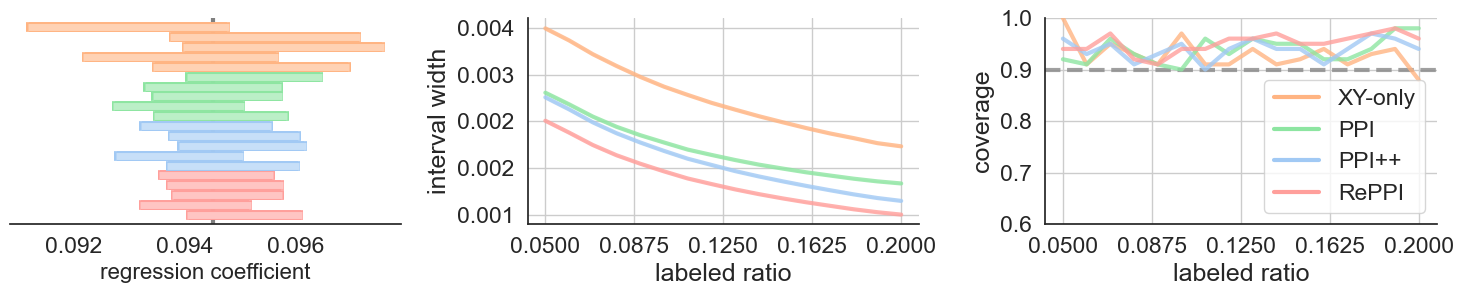

In [13]:
make_width_coverage_plot(df, "regression coefficient", "../results/census.pdf", theta_true, num_trials = num_trials, n_example_ind = 0)

In [14]:
df_width = make_length_table(df)
print(df_width)

     XY-only       PPI     PPI++     RePPI        n
0   0.003543  0.002432  0.002368  0.002065   6619.0
1   0.003372  0.002322  0.002258  0.001968   7304.0
2   0.003232  0.002223  0.002156  0.001885   7989.0
3   0.003108  0.002155  0.002085  0.001825   8674.0
4   0.002986  0.002076  0.002006  0.001759   9359.0
5   0.002889  0.002022  0.001948  0.001710  10043.0
6   0.002799  0.001964  0.001891  0.001664  10728.0
7   0.002710  0.001920  0.001843  0.001626  11413.0
8   0.002626  0.001874  0.001793  0.001586  12098.0
9   0.002551  0.001840  0.001753  0.001554  12783.0
10  0.002489  0.001796  0.001709  0.001517  13467.0
11  0.002427  0.001759  0.001669  0.001486  14152.0
12  0.002375  0.001729  0.001638  0.001460  14837.0
13  0.002316  0.001702  0.001608  0.001436  15522.0
14  0.002269  0.001680  0.001581  0.001416  16207.0
15  0.002224  0.001650  0.001548  0.001391  16891.0
16  0.002182  0.001632  0.001528  0.001373  17576.0
17  0.002136  0.001606  0.001500  0.001352  18261.0
18  0.002104

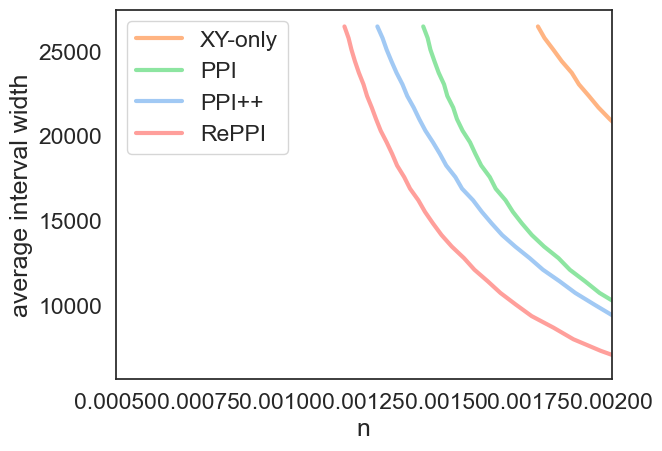

In [15]:
import matplotlib.pyplot as plt
for method in ["XY-only", "PPI", "PPI++", "RePPI"]:
    plt.plot(df_width[method], df_width['n'], label=method)
plt.ylabel('average interval width')
plt.xlim(0.0005, 0.002)
plt.xlabel('n')
plt.legend()

In [16]:
n_value = [0.0015, 0.0016, 0.0017, 0.0018, 0.0019, 0.0020]
interpolated_values = {}
for method in ["XY-only", "PPI", "PPI++", "RePPI"]:
    interpolated_values[method] = np.interp(n_value, df_width[method][::-1], df_width['n'][::-1])
print(interpolated_values)

{'XY-only': array([26479.        , 26479.        , 26479.        , 25728.18789271,
       23101.60640222, 20902.36637558]), 'PPI': array([22612.57605825, 18493.43977081, 15574.58491754, 13407.7775439 ,
       11712.44591075, 10300.60715946]), 'PPI++': array([18266.88192412, 15723.60422193, 13622.54351214, 11999.90432483,
       10614.50505892,  9431.46177198]), 'RePPI': array([13843.22585561, 11853.43156993, 10196.9552651 ,  8929.24805453,
        7863.55953279,  7075.78539471])}
